# 1. check keypoint and heatmap

In [1]:
import numpy as np

In [2]:
import lmdb
import numpy as np
import torch
import six
from torch.utils.data import Dataset
import json
from PIL import Image

import matplotlib.pyplot as plt
from pathlib import Path
import cv2

In [17]:
# Lmdb Dataset
class MgaLmdbDataset(Dataset):
    def __init__(self, cfg, lmdb_dir, indices, transforms):
        super().__init__()
        self.cfg = cfg
        self.transforms = transforms
        self.indices = indices
        self.env = lmdb.open(str(lmdb_dir), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        self.output_size = cfg.output_size
        self.sigma = cfg.sigma
        self.img_h, self.img_w = cfg.img_h, cfg.img_w
        self.heatmap_h, self.heatmap_w = cfg.heatmap_h, cfg.heatmap_w
    
    def _draw_msra_gaussian(self, heatmap, center, sigma):
        tmp_size = sigma * 6
        mu_x = int(center[0] + 0.5)
        mu_y = int(center[1] + 0.5)
        w, h = heatmap.shape[0], heatmap.shape[1]
        ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
        br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
        if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
            return heatmap
        size = 2 * tmp_size + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
        img_x = max(0, ul[0]), min(br[0], h)
        img_y = max(0, ul[1]), min(br[1], w)
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
        return heatmap

    def _create_heatmap(self, joints):
        '''
            joints: [(x1, y1), (x2, y2), ...]
            heatmap: size: (n_joints, hm_h, hm_w)
        '''
        heatmap = np.zeros((self.heatmap_h, self.heatmap_w), dtype=np.float32)
        for joint_id in range(len(joints)):
            heatmap = self._draw_msra_gaussian(heatmap, joints[joint_id], self.sigma)
        return heatmap
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = self.indices[idx]
        with self.env.begin(write=False) as txn:
            # load image
            img_key = f'image-{str(idx+1).zfill(8)}'.encode()
            imgbuf = txn.get(img_key)

            # load json
            label_key = f'label-{str(idx+1).zfill(8)}'.encode()
            label = txn.get(label_key).decode('utf-8')
        
        # image        
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        if self.cfg.input_size == 3:
            img = np.array(Image.open(buf).convert('RGB'))
        else:
            img = np.array(Image.open(buf).convert('L'))
        
        # label
        json_dict = json.loads(label)
        keypoints = [[dic['x'], dic['y']] for dic in json_dict['key_point']]
        kp_arr = np.array(keypoints)
        kp_min = np.amin(kp_arr, 0)
        if kp_min[0] < 0 or kp_min[1] < 0:
            # print(keypoints)
            print(json_dict['id'])

        transformed = self.transforms(image=img, keypoints=keypoints)
        img = transformed['image']
        keypoints = transformed['keypoints']
        
        keypoints_on_hm = np.array(keypoints) * \
            np.array([self.heatmap_w, self.heatmap_h]) / np.array([self.img_w, self.img_h])

        heatmap = self._create_heatmap(keypoints_on_hm)

        img = torch.from_numpy(img).permute(2, 0, 1)
        heatmap = torch.from_numpy(heatmap)

        return img, heatmap

In [28]:
class cfg:
    input_size = 3
    output_size = 196
    sigma = 2
    img_h = 300
    img_w = 500
    heatmap_h = 80
    heatmap_w = 128
    img_mean = [0.485, 0.456, 0.406]
    img_std = [0.229, 0.224, 0.225]

In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import KeypointParams

In [30]:
def get_transforms(cfg):
    return A.Compose([
        A.RandomResizedCrop(height=cfg.img_h, width=cfg.img_w, scale=(0.8, 1.0)),
        A.ShiftScaleRotate(p=1),
        A.Normalize(mean=cfg.img_mean, std=cfg.img_std)
    ], keypoint_params=KeypointParams(format='xy'))

In [31]:
ROOT_DIR = Path.cwd().parents[2]
LMDB_DIR = ROOT_DIR / 'data' / 'data0002' / 'lmdb'

In [32]:
ds = MgaLmdbDataset(cfg, LMDB_DIR, [1, 2, 3], transforms=get_transforms(cfg))

In [33]:
img, hm = ds.__getitem__(1)

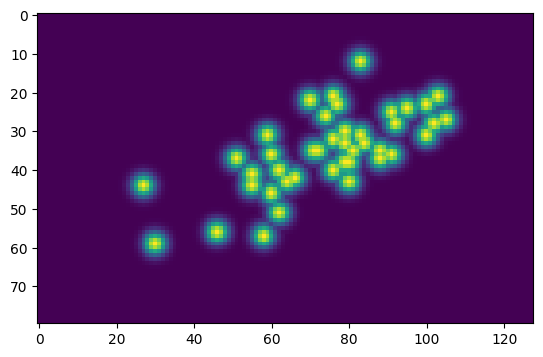

In [34]:
plt.imshow(hm)

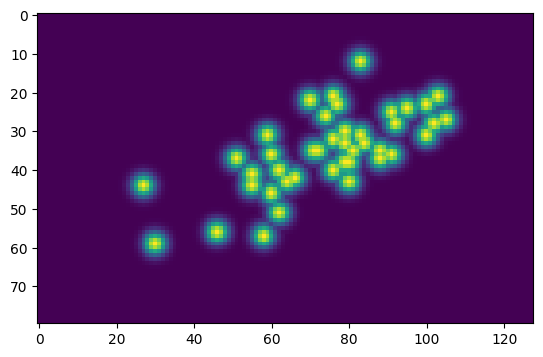

In [57]:
plt.imshow(hm)

In [72]:
np.argsort(hm.ravel())

tensor([   0, 7180, 7179,  ..., 4551, 5568, 3676])

In [66]:
# 平坦化してインデックスを取得
flat_indices = np.argsort(hm.ravel())

# 平坦化したインデックスを元の2次元配列のインデックスに変換
indices = np.column_stack(np.unravel_index(flat_indices, hm.shape))

In [73]:
indices[-5:, :]

array([[26, 74],
       [25, 91],
       [35, 71],
       [43, 64],
       [28, 92]])

In [78]:
ys, xs = np.where(hm == 1)

In [79]:
xs

array([ 83,  76, 103,  70,  77, 100,  95,  91,  74, 105,  92, 102,  79,
        59,  83, 100,  76,  79,  84,  71,  72,  81,  88,  60,  91,  51,
        88,  79,  80,  62,  76,  55,  66,  64,  80,  27,  55,  60,  62,
        46,  58,  30])

In [77]:
ys

array([ 83,  76, 103,  70,  77, 100,  95,  91,  74, 105,  92, 102,  79,
        59,  83, 100,  76,  79,  84,  71,  72,  81,  88,  60,  91,  51,
        88,  79,  80,  62,  76,  55,  66,  64,  80,  27,  55,  60,  62,
        46,  58,  30])

In [74]:
target_xs = [3, 6, 7, 2]
target_ys = [1, 4, 5, 6]

set((x, y) for x, y in zip(target_xs, target_ys))

{(2, 6), (3, 1), (6, 4), (7, 5)}

In [70]:
hm[56, 11]

tensor(0.)

In [50]:
m = np.where(hm==1., 1, 0)

In [51]:
m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


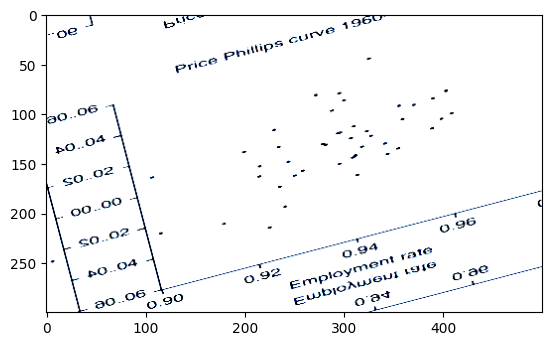

In [35]:
plt.imshow(img.permute(1, 2, 0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


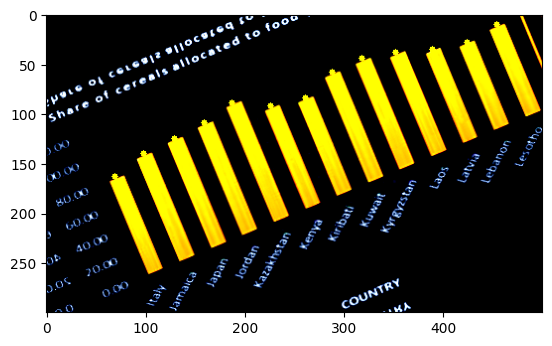

In [209]:
plt.imshow(draw_img)

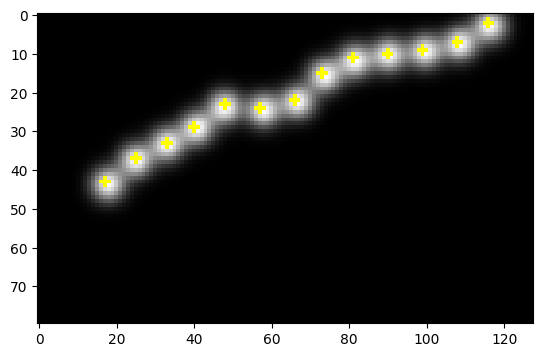

In [210]:
hm_img = np.sum(hm, axis=0)
draw_hm_img = hm_img.copy()
draw_hm_img = np.transpose(np.tile(draw_hm_img, (3, 1, 1)), (1, 2, 0))
draw_hm_img = draw_hm_img * 255 / draw_hm_img.max()
draw_hm_img = draw_hm_img.astype(np.int32).copy()
for coor in kp_on_hm:
    cv2.circle(draw_hm_img, (int(coor[0]), int(coor[1])), 1, (255, 255, 0), -1)
plt.imshow(draw_hm_img)

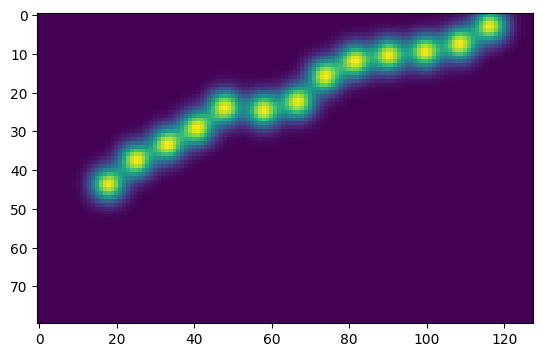

In [211]:
plt.imshow(hm.sum(axis=0))

In [126]:
kp_on_hm

array([[ 28.76901798,  21.90007822],
       [ 35.96127248,  19.26052763],
       [ 43.15352697,  18.73261751],
       [ 50.06915629,  17.94075233],
       [ 56.98478562,  16.09306691],
       [ 64.17704011,  20.44832539],
       [ 71.36929461,  21.90007822],
       [ 78.5615491 ,  18.73261751],
       [ 85.47717842,  18.33668492],
       [ 92.39280775,  20.31634786],
       [ 99.58506224,  23.00558755],
       [106.77731674,  24.6744992 ],
       [113.96957123,  23.56189143],
       [120.88520055,  20.58030292],
       [127.80082988,  18.73261751]])